In [ ]:
from css_code import toric_code_matrices
import matplotlib.pyplot as plt
import numpy as np
from ldpc import BpDecoder, BpOsdDecoder
from decoder_performance import compute_logical_error_rate

# compare between BP and BP+OSD decoders with different distances of the toric code

distances = [9, 11, 13, 15]
error_rates = np.linspace(0.01, 0.13, 13)  # Error rates from 0.01 to 0.1
max_iter = 60
ms_scaling_factor = 0.625
osd_order = 60  # Order of the OSD method
run_count = 100000 # Number of runs for each error rate
logical_error_rates_bp = []
logical_error_rates_bp_osd = []

for d in distances:
    print(f"Distance: {d}")
    logical_error_rates_bp_with_d = []
    logical_error_rates_bp_osd_with_d = []
    Hx, Hz, Lx, Lz = toric_code_matrices(d)
    # remove the last row of Hx and Hz
    Hx = Hx[:-1, :]
    Hz = Hz[:-1, :]
    # H = vstack([Hx, Hz])

    for p in error_rates:
        # Initialize the BP decoder
        bp_decoder = BpDecoder(
        pcm=Hz,
        error_rate=float(p),
        max_iter=max_iter,
        ms_scaling_factor=ms_scaling_factor,
        schedule='parallel',
        )

        logical_error_rate_bp = compute_logical_error_rate(
            Hz, Lz, p, run_count=run_count, DECODER=bp_decoder, run_label=f"BP (d={d}, p={p})"
        )
        logical_error_rates_bp_with_d.append(logical_error_rate_bp)

        bp_osd_decoder = BpOsdDecoder(
            pcm=Hz,
            error_rate=float(p),
            max_iter=max_iter,
            ms_scaling_factor=ms_scaling_factor,
            schedule='parallel',
            osd_method='OSD_CS',
            osd_order=osd_order,
        )
        logical_error_rate_bp_osd = compute_logical_error_rate(
            Hz, Lz, p, run_count=run_count, DECODER=bp_osd_decoder, run_label=f"BP+OSD (d={d}, p={p})"
        )
        logical_error_rates_bp_osd_with_d.append(logical_error_rate_bp_osd)
    
    logical_error_rates_bp.append(logical_error_rates_bp_with_d)
    logical_error_rates_bp_osd.append(logical_error_rates_bp_osd_with_d)


Distance: 9
Decoder BP (d=9, p=0.01) finished in 0.95 seconds with 471 failures out of 10000 runs.
Logical error rate for BP (d=9, p=0.01): 0.0471
Decoder BP+OSD (d=9, p=0.01) finished in 1.77 seconds with 0 failures out of 10000 runs.
Logical error rate for BP+OSD (d=9, p=0.01): 0.0000
Decoder BP (d=9, p=0.02) finished in 1.82 seconds with 1565 failures out of 10000 runs.
Logical error rate for BP (d=9, p=0.02): 0.1565
Decoder BP+OSD (d=9, p=0.02) finished in 4.84 seconds with 0 failures out of 10000 runs.
Logical error rate for BP+OSD (d=9, p=0.02): 0.0000
Decoder BP (d=9, p=0.03) finished in 2.98 seconds with 3021 failures out of 10000 runs.
Logical error rate for BP (d=9, p=0.03): 0.3021
Decoder BP+OSD (d=9, p=0.03) finished in 9.15 seconds with 6 failures out of 10000 runs.
Logical error rate for BP+OSD (d=9, p=0.03): 0.0006
Decoder BP (d=9, p=0.04) finished in 3.87 seconds with 4170 failures out of 10000 runs.
Logical error rate for BP (d=9, p=0.04): 0.4170
Decoder BP+OSD (d=9, p

Logical error rates for BP decoders:
[[0.0471, 0.1565, 0.3021, 0.417, 0.5757, 0.7057, 0.8189, 0.8876, 0.9282, 0.9666, 0.9811, 0.9923, 0.9965], [0.0647, 0.2101, 0.4164, 0.5682, 0.7322, 0.8418, 0.9104, 0.9625, 0.9806, 0.9937, 0.9974, 0.9992, 0.9998], [0.0888, 0.2977, 0.5293, 0.6973, 0.8499, 0.9228, 0.9699, 0.9891, 0.9958, 0.9989, 0.9998, 0.9999, 1.0], [0.1166, 0.3808, 0.6403, 0.8009, 0.9179, 0.9675, 0.9925, 0.9972, 0.9996, 0.9999, 0.9999, 1.0, 1.0]]
Logical error rates for BP+OSD decoders:
[[0.0, 0.0, 0.0006, 0.0028, 0.008, 0.0206, 0.0431, 0.09, 0.1598, 0.2237, 0.3024, 0.3848, 0.4622], [0.0, 0.0, 0.0001, 0.0011, 0.0036, 0.0135, 0.0354, 0.0801, 0.1443, 0.2202, 0.3088, 0.4076, 0.4905], [0.0, 0.0, 0.0, 0.0001, 0.0017, 0.0107, 0.0285, 0.0653, 0.128, 0.2201, 0.3139, 0.4271, 0.5183], [0.0, 0.0, 0.0002, 0.0, 0.0012, 0.005, 0.0201, 0.0597, 0.1265, 0.2186, 0.3307, 0.4453, 0.5449]]


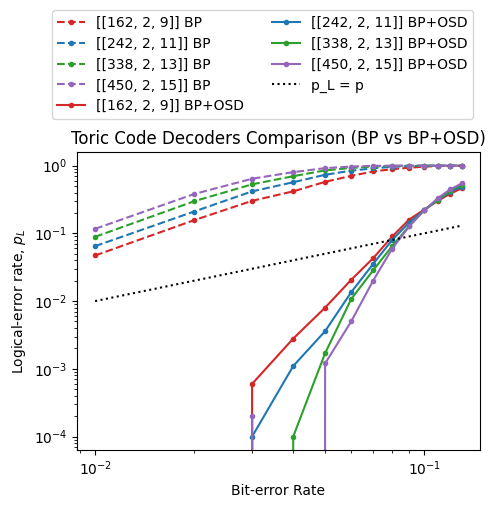

In [9]:
print("Logical error rates for BP decoders:")
print(logical_error_rates_bp)
print("Logical error rates for BP+OSD decoders:")
print(logical_error_rates_bp_osd)

colors = {
    9: 'tab:red',
    11: 'tab:blue',
    13: 'tab:green',
    15: 'tab:purple'
}

plt.figure(figsize=(5, 6))
plt.title("Toric Code Decoders Comparison (BP vs BP+OSD)")
plt.xlabel("Bit-error Rate")
plt.ylabel(r"Logical-error rate, $p_L$")
plt.xscale('log')
plt.yscale('log')

# Use different loop variables to avoid overwriting
for d, bp_vals in zip(distances, logical_error_rates_bp):
    # if d == 9 or d == 11:
    #     continue
    plt.plot(
        error_rates, bp_vals,
        label=f"[[{2 * d**2}, 2, {d}]] BP",
        marker='.',
        linestyle='--',
        color=colors[d]
    )

for d, bp_osd_vals in zip(distances, logical_error_rates_bp_osd):
    plt.plot(
        error_rates, bp_osd_vals,
        label=f"[[{2 * d**2}, 2, {d}]] BP+OSD",
        marker='.',
        linestyle='-',
        color=colors[d]
    )

plt.plot(error_rates, error_rates, label="p_L = p", linestyle=':', color='black')

plt.legend(bbox_to_anchor=(1, 1.5), ncol=2)
plt.tight_layout()
plt.show()


/var/folders/qm/b1zgl4n51dx4f08pr04pv_k80000gq/T/ipykernel_60647/3587356347.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


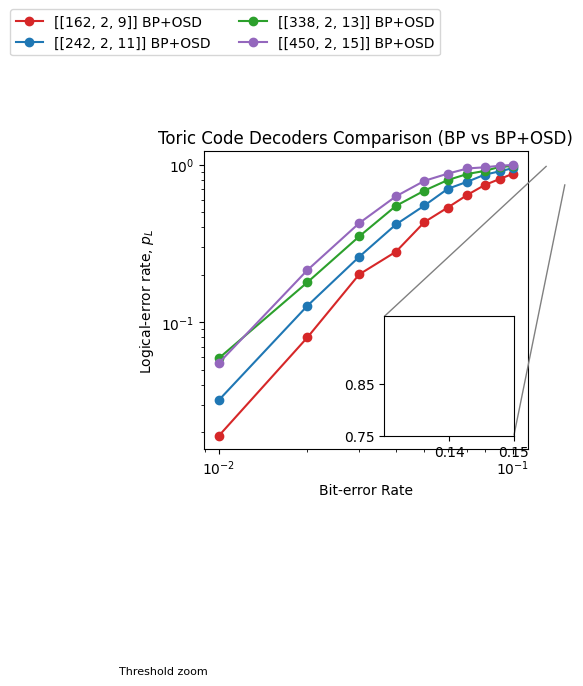

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

colors = {
    9: 'tab:red',
    11: 'tab:blue',
    13: 'tab:green',
    15: 'tab:purple'
}

fig, ax = plt.subplots(figsize=(5, 6))
ax.set_title("Toric Code Decoders Comparison (BP vs BP+OSD)")
ax.set_xlabel("Bit-error Rate")
ax.set_ylabel(r"Logical-error rate, $p_L$")
ax.set_xscale('log')
ax.set_yscale('log')

for d, bp_vals in zip(distances, logical_error_rates_bp):
    ax.plot(
        error_rates, bp_vals,
        label=f"[[{2 * d**2}, 2, {d}]] BP",
        marker='o',
        linestyle='--',
        color=colors[d]
    )

for d, bp_osd_vals in zip(distances, logical_error_rates_bp_osd):
    ax.plot(
        error_rates, bp_osd_vals,
        label=f"[[{2 * d**2}, 2, {d}]] BP+OSD",
        marker='o',
        linestyle='-',
        color=colors[d]
    )

# Add zoomed inset
axins = inset_axes(ax, width="40%", height="40%", loc='lower right', borderpad=1)
axins.set_xlim(0.13, 0.149)  # Adjust x-limits to zoom into threshold
axins.set_ylim(0.75, 0.98)     # Adjust y-limits to match threshold region
axins.set_xticks([0.14, 0.15])
axins.set_yticks([0.75, 0.85])

for d, bp_vals in zip(distances, logical_error_rates_bp):
    axins.plot(error_rates, bp_vals, marker='o', linestyle='--', color=colors[d])

for d, bp_osd_vals in zip(distances, logical_error_rates_bp_osd):
    axins.plot(error_rates, bp_osd_vals, marker='o', linestyle='-', color=colors[d])

# Add rectangle connector lines between main plot and inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# Add label to inset
axins.text(0.089, 0.29, "Threshold zoom", fontsize=8)

ax.legend(bbox_to_anchor=(0.75, 1.5), ncol=2)
fig.tight_layout()
plt.show()
